In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset


import os
import os.path

from torchsummary import summary

import random
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


INIZIAMO COL CREARE I DATASET, PER QUESTO CI SERVIRà


1.   generare i valori di k allinterno della zona di Brilloins (x)
2.   generare una hamiltoniana di TB con i parametri(presi come reali) e da questi calcolare gli autovalori (y)
3.   mettere tutto nel dataloader (set_training, evalutation_set)






In [ ]:
def bande (k,Nsimulazioni,e,t1,t2,d):
  eig = np.zeros((Nsimulazioni, 2))

  for i in range(Nsimulazioni):


    eig[i][0] = e + t1 + t2*np.cos(k[i]*d)
    eig[i][1] = e - t1 - t2*np.cos(k[i]*d)




  return (eig)

In [ ]:
class set(Dataset):
  def __init__(self,features,targets):
    self.x=torch.from_numpy(features).float()
    self.y=torch.from_numpy(targets).float()


    print(features.shape[0])
    self.n_samples = features.shape[0]

    self.x=(self.x).view(self.n_samples,-1)
    print(self.x.shape)

    self.y=(self.y).view(targets.shape,-1)
    print(self.y.shape)

  def __getitem__(self, index):
    return self.x[index],self.y[index]

  def __len__(self):
    return self.n_samples

400
torch.Size([400, 1])
torch.Size([400, 2])
100
torch.Size([100, 1])
torch.Size([100, 2])


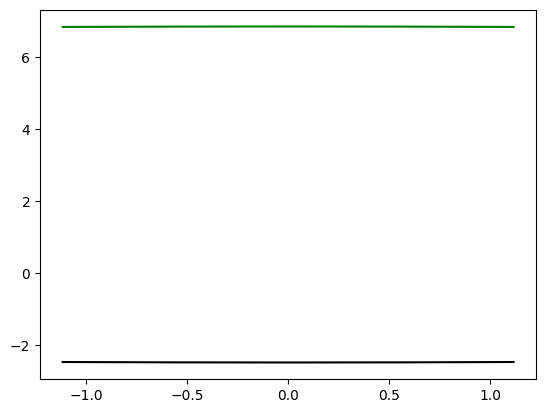

In [ ]:

  e_true = np.random.uniform(0,5)
  t1_true = np.random.uniform(0,5)
  t2_true = np.random.uniform(0,5)
  d_true = np.random.uniform(0,2)

  k = np.linspace(-(np.pi)/2*d_true, (np.pi)/2*d_true, 500)
  y= bande(k,500,e_true,t1_true,t2_true,d_true)

  plt.plot((k), y[:,0], color='green', linestyle='-', label='banda1')
  plt.plot((k), y[:,1], color='black', linestyle='-', label='banda2')
  x_train,x_vali,y_train,y_vali = train_test_split(k,(y),train_size=0.8, shuffle=True, random_state=1234)
  dataset_train= set(features=x_train,targets=y_train)
  dataset_vali= set(features=x_vali,targets=y_vali)


INIZIAMO A SETTARE TUTTO PER IL TRAINING



1.   Definisco le matrici HNN e HTB per calcalare la loss
2.   definisco il modello NN che approssima gli autovettori prendendo in entrata k
3.   Definisco il modello che aggiorna i parametri dell'hamiltoniana TB
4.   





In [ ]:
def HTB (k,Nsimulazioni,e,t1,t2,d):
  HTB = torch.zeros((Nsimulazioni, 4))
  for i in range(Nsimulazioni):
    HTB[i][0]=  e
    HTB[i][1] = - t2*torch.cos(k[i]*d) - t1
    HTB[i][2] = HTB[i][1]
    HTB[i][3] = e
  return (HTB)

In [ ]:
def HNN (eigv,eig,Nsimulazioni):
  HNN = torch.zeros((Nsimulazioni, 4))
  for i in range(Nsimulazioni):
    HNN[i][0] = eig[i][0]*(torch.cos(eigv[i])*torch.cos(eigv[i])) + eig[i][1]*(torch.sin(eigv[i])*torch.sin(eigv[i]))
    HNN[i][1] = (eig[i][0]-eig[i][1])*torch.cos(eigv[i])*torch.sin(eigv[i])
    HNN[i][2] = HNN[i][1]
    HNN[i][3] = HNN[i][0]

  return (HNN)

In [ ]:
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(0))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [ ]:
# costruzione della NN

from torch.nn.modules.activation import ReLU
# andiamo a configurare la nostra rete
from torch import nn
import torch.nn.functional as F

class ShallowMLP(nn.Module):
  def __init__(self, depth =128 ):
    super(ShallowMLP, self).__init__()

    # costruisco dei layer ad attivazione lineare, però mettendoci esplicitamente l'attivazione relu dopo
    self.layer1 = nn.Linear(1, depth)
    self.layer2 = nn.Linear(depth, depth)
    self.layer3 = nn.Linear(depth,1)
    self.dropout= nn.Dropout(p=0.3)



    # costruisco la sequenza

  def forward (self,x):


    x=self.layer1(x)
    x=F.relu(x)
    x=self.dropout(x)
    x=self.layer2(x)
    x=F.relu(x)
    x=self.dropout(x)
    x=self.layer3(x)
    out = x
    return out

In [ ]:
# costruisco il modello per la TB
import random
import torch.nn as nn

class parameters (nn.Module):
  def __init__(self):
    super(parameters, self).__init__()

    self.e = torch.nn.Parameter(torch.rand(1)*5,requires_grad = True)

    self.t1 = torch.nn.Parameter(torch.rand(1)*5,requires_grad = True)
    self.t2 = torch.nn.Parameter(torch.rand(1)*5,requires_grad = True)

    self.d = torch.nn.Parameter(torch.rand(1)*2,requires_grad = True)

  def forward (self):

    e=self.e

    t1=self.t1
    t2=self.t2

    d=self.d

    return (e,t1,t2,d)


In [ ]:
def accuracy (par,e,t1,t2,d):
  dp =(((e - par[0])**2) +  ((t1 - par[1])**2) + ((t2- par[2])**2) + ((d- par[3])**2) )
  accuracy =100/(1+dp)
  return(accuracy)

In [ ]:
# Hyperparameters
learning_rate = [0.0001, 0.001, 0.01, 0.1]
learning_rate2 = [0.0001,0.001, 0.01, 0.1]
batch_size = [5, 10 , 20, 30]
depth=[2**2,2**4,2**6,2**8]
epochs=[10, 20, 30 , 50]

In [ ]:
# Hyperparameters
learning_rate = [0.001, 0.01]
learning_rate2 = [0.001, 0.01]
batch_size = [5, 10 ]
depth=[2**2,2**4]
drop_out=[0.3, 0.5]
epochs=[50, 100]

In [ ]:
# Hyperparameters
learning_rate = [0.001, 0.01]
learning_rate2 = [0.001, 0.01]
batch_size = [5, 10 ]
depth=[64, 128]
drop_out=[0.3, 0.5]
epochs=[10, 20]

In [ ]:
# Hyperparameters
learning_rate = [0.001]
learning_rate2 = [0.001]
batch_size = [ 10 ]
depth=[64, 128]
drop_out=[0.3, 0.5]
epochs=[ 50]

In [ ]:
# Hyperparameters
learning_rate = [0.001]
learning_rate2 = [0.001]
batch_size = [5 ]
epochs=[ 20]

In [ ]:
def train (model, modelTB, criterion ,optimazer1, optimazer2, epochs, batch, train_dl , vali_dl, e1_true, t11_true, t22_true, d_true):
  hist_vloss = []
  hist_vmetric = []
  for epoch in range(epochs):


    # training step
    model.train()
    modelTB.train()

    train_loss = 0
    train_metric = 0
    counter = 0

    for xb, yb in train_dl:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        # preparazione dei dati
        xb = xb.view(batch,1)
        yb = yb.view(batch,2)

        #predizione del modello
        vector = model(xb)      #autovettori di dimensione
        par = modelTB()

        NN=HNN(vector,yb,batch)
        TB=HTB(xb,batch,par[0],par[1],par[2],par[3])


        # calcolo loss e metrica

        loss = loss_func(NN,TB)


        # aggiorno la loss e metrica totale
        train_loss += loss.item()


        # backpropagation
        optNN.zero_grad()
        optTB.zero_grad()
        loss.backward()


        optNN.step()
        optTB.step()

    # validation step
    model.eval()
    modelTB.eval()


    vali_loss = 0
    vali_metric = 0
    counter = 0

    with torch.no_grad():
      for xb, yb in vali_dl:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)


        # preparazione dati
        xb = xb.view(batch,1)
        yb = yb.view(batch,2)

        vector = model(xb)      #autovettori di dimensione
        par = modelTB()

        NN=HNN(vector,yb,batch)

        TB=HTB(xb,batch,par[0],par[1],par[2],par[3])

        vloss= loss_func(NN,TB)
        vali_loss += vloss.item()
    par=modelTB()
    vali_metric=accuracy(par, e_true, t1_true, t2_true, d_true)
    vali_loss /= counter
    hist_vloss.append(vali_loss)
    vali_metric=vali_metric.item()
    hist_vmetric.append(vali_metric)
  return vali_loss, vali_metric ,hist_vloss, hist_vmetric

num_epochs: 20, batch_size : 5 ,  learning_rateNN: 0.0010, learning_rateTB: 0.0010, vali loss: 0.000354, vali metric: 4.080637
{'learning_rate': 0.001, 'learning_rate2': 0.001, 'batch_size': 5, 'num_epochs': 20}


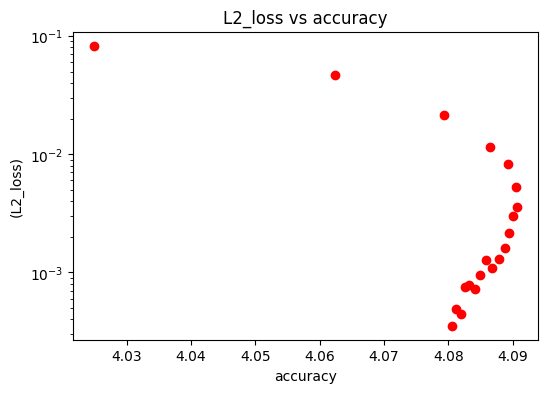

Best hyperparameters: {'learning_rate': 0.001, 'learning_rate2': 0.001, 'batch_size': 5, 'num_epochs': 20}
Best score: 0.00035415933234617114


In [ ]:
# Hyperparameter tuning
best_score = 100
best_params = None


for lr in learning_rate:
  for lr2 in learning_rate2:
    for bs in batch_size:
        for ne in epochs:
            # Create DataLoaders with current batch_size
            train_dl= DataLoader(dataset=dataset_train, batch_size=bs, shuffle=True, drop_last= True)
            vali_dl= DataLoader(dataset=dataset_vali, batch_size=bs, shuffle=True, drop_last= True)

            # Initialize the model, loss function, and optimizer with current learning_rate
            modelTB = parameters()
            model = ShallowMLP()
            modelTB.to(device)
            model.to(device)
            loss_func = nn.MSELoss()
            optNN = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            optTB = optim.SGD(modelTB.parameters(), lr=lr2, momentum=0.9)

            # Train and evaluate the model
            current_score = train(model, modelTB, loss_func , optNN, optTB , ne , bs , train_dl , vali_dl, e_true, t1_true, t2_true, d_true)

            print("num_epochs: %d, batch_size : %d ,  learning_rateNN: %.4f, learning_rateTB: %.4f, vali loss: %f, vali metric: %f" % (ne, bs, lr, lr2, current_score[0], current_score[1]))


            # Update best_score and best_params if current_score is better
            if current_score[0] < best_score:
                best_score = current_score[0]
                best_params = {'learning_rate': lr,'learning_rate2': lr2, 'batch_size': bs, 'num_epochs': ne}
                torch.save({'model1' : model,
                        'model2' : modelTB,

                        'model_state_dict': model.state_dict(),
                        'modelTB_state_dict': modelTB.state_dict(),
                        'optimizer1_state_dict': optNN.state_dict(),
                        'optimizer2_state_dict': optTB.state_dict(),


                }, 'best_model.pt')
                print(best_params)

                plt.figure(figsize=(6, 4))

                plt.title('L2_loss vs accuracy')
                plt.scatter(current_score[3], current_score[2], color='red', marker='o')

                plt.yscale('log')
                plt.xlabel('accuracy')
                plt.ylabel('(L2_loss)')

                plt.show()
print("Best hyperparameters:", best_params)
print("Best score:", best_score)

In [ ]:
model_data = torch.load('./best_model.pt')

model=model_data['model1']
modelTB=model_data['model2']


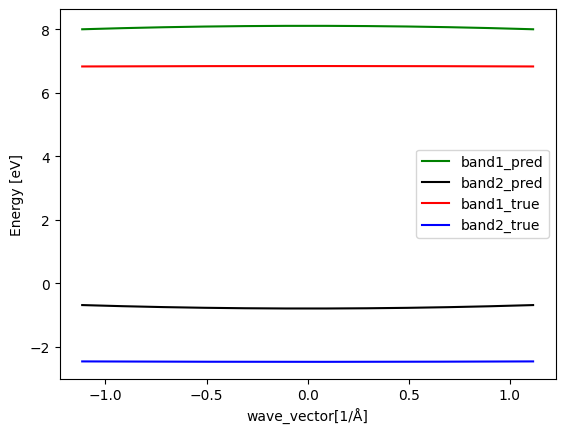

In [ ]:
modelTB.to(torch.device('cpu'))
par=modelTB()


x= bande(k,500,par[0].detach().numpy(),par[1].detach().numpy(),par[2].detach().numpy(),par[3].detach().numpy())

plt.plot((k), x[:,0], color='green', linestyle='-', label='band1_pred')
plt.plot((k), x[:,1], color='black', linestyle='-', label='band2_pred')
plt.plot((k), y[:,0], color='red', linestyle='-', label='band1_true')
plt.plot((k), y[:,1], color='blue', linestyle='-', label='band2_true')
plt.ylabel('Energy [eV]')
plt.xlabel('wave_vector[1/Å]')
plt.legend()
plt.show()

In [ ]:
print(e_true,t1_true,t2_true,d_true)

2.18055461829708 4.61369214884189 0.04410821032098167 0.7099523242194907


In [ ]:
print(par)

(Parameter containing:
tensor([3.6534], requires_grad=True), Parameter containing:
tensor([1.2633], requires_grad=True), Parameter containing:
tensor([3.1882], requires_grad=True), Parameter containing:
tensor([0.2346], requires_grad=True))


In [ ]:
e= 0
t1 = 2.796
t2= 2.242
d= 1.479
# d= 2.479
k = np.linspace(-(np.pi)/2*d, (np.pi)/2*d, 500)
x= bande(k,500,e,t1,t2,d)

bs=5

x_train,x_vali,y_train,y_vali = train_test_split(k,(x),train_size=0.8, shuffle=True, random_state=1234)
dataset_train= set(features=x_train,targets=y_train)
dataset_vali= set(features=x_vali,targets=y_vali)
train_dl= DataLoader(dataset=dataset_train, batch_size=bs, shuffle=True, drop_last= True)
vali_dl= DataLoader(dataset=dataset_vali, batch_size=bs, shuffle=True, drop_last= True)

400
torch.Size([400, 1])
torch.Size([400, 2])
100
torch.Size([100, 1])
torch.Size([100, 2])


In [ ]:
import time


model.to(torch.device('cpu'))
modelTB.to(torch.device('cpu'))

optNN = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optTB = optim.SGD(modelTB.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.MSELoss()
# numero di epoche
epochs = 10

batch=5

hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []



# loop sulle epoche
for epoch in range(epochs):


    t0 = time.time()


    # training step
    model.train()
    modelTB.train()

    train_loss = 0
    train_metric = 0
    counter = 0

    for xb, yb in train_dl:
        counter += 1
        xb=xb.to(torch.device('cpu'))
        yb=yb.to(torch.device('cpu'))

        # preparazione dei dati
        xb = xb.view(bs,1)
        yb = yb.view(bs,2)

        #predizione del modello
        vector = model(xb)
        par = modelTB()

        NN=HNN(vector,yb,bs)
        TB=HTB(xb,bs,par[0],par[1],par[2],par[3])



        loss = loss_func(NN,TB)


        # aggiorno la loss
        train_loss += loss.item()


        # backpropagation
        optNN.zero_grad()
        optTB.zero_grad()
        loss.backward()


        optNN.step()
        optTB.step()


    train_loss /= counter

    hist_loss.append(train_loss)
    hist_metric.append(accuracy)

    # validation step
    model.eval()

    vali_loss = 0
    vali_metric = 0
    counter = 0

    with torch.no_grad():
      for xb, yb in vali_dl:
        counter += 1
        xb=xb.to(torch.device('cpu'))
        yb=yb.to(torch.device('cpu'))


        # preparazione dati
        xb = xb.view(bs,1)
        yb = yb.view(bs,2)

        vector = model(xb)
        par = modelTB()

        NN=HNN(vector,yb,bs)

        TB=HTB(xb,bs,par[0],par[1],par[2],par[3])



        # calcolo loss
        vloss = loss_func(NN,TB)




        vali_loss += vloss.item()



    vali_loss /= counter
    vali_metric /= (counter*batch)
    hist_vloss.append(vali_loss)
    dp =(((0 - par[0])**2) +  ((2.796- par[1])**2) + ((2.242- par[2])**2) + ((1.479- par[3])**2) )
    accuracy =100/(1+dp)
    hist_vmetric.append(accuracy)




    # save_best_model(vali_loss, epoch, model,modelTB , optNN, optTB, loss_func, accuracy)
    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.8f, vali loss: %.6f, vali metric: %.8f"
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, accuracy))

epoch: 1, time(s): 0.5351, train loss: 1.219784, train metric: 0.00000000, vali loss: 0.070051, vali metric: 52.06988525
epoch: 2, time(s): 0.5339, train loss: 0.043544, train metric: 0.00000000, vali loss: 0.007103, vali metric: 91.66009521
epoch: 3, time(s): 0.5181, train loss: 0.004980, train metric: 0.00000000, vali loss: 0.005272, vali metric: 98.29793549
epoch: 4, time(s): 0.5027, train loss: 0.001032, train metric: 0.00000000, vali loss: 0.000321, vali metric: 99.56671143
epoch: 5, time(s): 0.5330, train loss: 0.000314, train metric: 0.00000000, vali loss: 0.000173, vali metric: 99.82788849
epoch: 6, time(s): 0.5274, train loss: 0.000305, train metric: 0.00000000, vali loss: 0.000343, vali metric: 99.91058350
epoch: 7, time(s): 0.5287, train loss: 0.000142, train metric: 0.00000000, vali loss: 0.000157, vali metric: 99.96829224
epoch: 8, time(s): 0.5206, train loss: 0.000102, train metric: 0.00000000, vali loss: 0.000038, vali metric: 99.98410034
epoch: 9, time(s): 0.5420, train

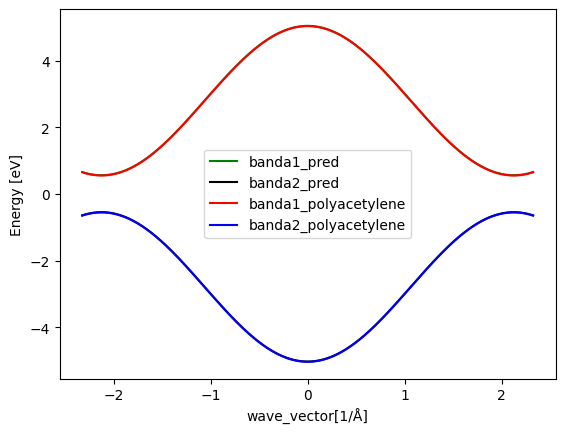

In [ ]:
par=modelTB()

k= np.linspace(-(np.pi)/2*1.479, (np.pi)/2*1.479, 500)
z= bande(k,500,par[0].detach().numpy(),par[1].detach().numpy(),par[2].detach().numpy(),par[3].detach().numpy())


plt.plot((k), z[:,0], color='green', linestyle='-', label='banda1_pred')
plt.plot((k), z[:,1], color='black', linestyle='-', label='banda2_pred')
plt.plot((k), x[:,0], color='red', linestyle='-', label='banda1_polyacetylene')
plt.plot((k), x[:,1], color='blue', linestyle='-', label='banda2_polyacetylene')

plt.ylabel('Energy [eV]')
plt.xlabel('wave_vector[1/Å]')

plt.legend()
plt.show()


In [ ]:
print(par)

(Parameter containing:
tensor([0.0090], requires_grad=True), Parameter containing:
tensor([2.7959], requires_grad=True), Parameter containing:
tensor([2.2421], requires_grad=True), Parameter containing:
tensor([1.4790], requires_grad=True))
